<a href="https://colab.research.google.com/github/MarZaj1278/SomeDSstuff/blob/master/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

Playing around with an autoencoder using the human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

# Data you need

Download it using following links and upload it to your Google Colab working directory
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

Credits to: https://www.coursera.org/learn/intro-to-deep-learning 

# Import stuff

In [0]:
import sys
sys.path.append("..")

In [0]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [0]:
_# tqdm_utils
from __future__ import print_function
import tqdm
tqdm.monitor_interval = 0  


class SimpleTqdm():
    def __init__(self, iterable=None, total=None, **kwargs):
        self.iterable = list(iterable) if iterable is not None else None
        self.total = len(self.iterable) if self.iterable is not None else total
        assert self.iterable is not None or self.total is not None
        self.current_step = 0
        self.print_frequency = max(self.total // 50, 1)
        self.desc = ""

    def set_description_str(self, desc):
        self.desc = desc

    def set_description(self, desc):
        self.desc = desc

    def update(self, steps):
        last_print_step = (self.current_step // self.print_frequency) * self.print_frequency
        i = 1
        while last_print_step + i * self.print_frequency <= self.current_step + steps:
            print("*", end='')
            i += 1
        self.current_step += steps

    def close(self):
        print("\n" + self.desc)

    def __iter__(self):
        assert self.iterable is not None
        self.index = 0
        return self

    def __next__(self):
        if self.index < self.total:
            element = self.iterable[self.index]
            self.update(1)
            self.index += 1
            return element
        else:
            self.close()
            raise StopIteration


def tqdm_notebook_failsafe(*args, **kwargs):
    try:
        return tqdm.tqdm_notebook(*args, **kwargs)
    except:
        # tqdm is broken on Google Colab
        return SimpleTqdm(*args, **kwargs)


In [0]:
# Callbacks
from collections import defaultdict
from keras.models import save_model
import keras

class TqdmProgressCallback(keras.callbacks.Callback):

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        print('\nEpoch %d/%d' % (epoch + 1, self.epochs))
        if "steps" in self.params:
            self.use_steps = True
            self.target = self.params['steps']
        else:
            self.use_steps = False
            self.target = self.params['samples']
        self.prog_bar = tqdm_notebook_failsafe(total=self.target)
        self.log_values_by_metric = defaultdict(list)

    def _set_prog_bar_desc(self, logs):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values_by_metric[k].append(logs[k])
        desc = "; ".join("{0}: {1:.4f}".format(k, np.mean(values)) for k, values in self.log_values_by_metric.items())
        if hasattr(self.prog_bar, "set_description_str"):  # for new tqdm versions
            self.prog_bar.set_description_str(desc)
        else:
            self.prog_bar.set_description(desc)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        if self.use_steps:
            self.prog_bar.update(1)
        else:
            batch_size = logs.get('size', 0)
            self.prog_bar.update(batch_size)
        self._set_prog_bar_desc(logs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self._set_prog_bar_desc(logs)
        self.prog_bar.update(1)  # workaround to show description
        self.prog_bar.close()


class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


In [5]:
# Mount Colab at your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import cv2
import pandas as pd
import tarfile


ATTRS_NAME = "/content/gdrive/My Drive/Colab Notebooks/lfw_attributes.txt"  # http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
IMAGES_NAME = "/content/gdrive/My Drive/Colab Notebooks/lfw-deepfunneled.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
RAW_IMAGES_NAME = "/content/gdrive/My Drive/Colab Notebooks/lfw.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw.tgz


def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs.columns = list(df_attrs.columns)[1:] + ["NaN"]
    df_attrs = df_attrs.drop("NaN", axis=1)
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm_notebook_failsafe(f.getmembers()):
            if m.isfile() and m.name.endswith(".jpg"):
                # prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                # parse person
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

Prepare data for training and testing

In [7]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [0]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


20376

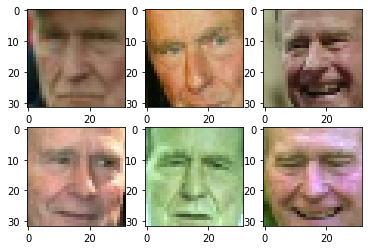

In [9]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

# Autoencoder architectures


# 1. PCA as autoencoder


In [0]:
def build_pca_autoencoder(img_shape, code_size):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Meld them together into one model:

In [11]:
encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                callbacks=[TqdmProgressCallback()],
                verbose=1)

Train on 11828 samples, validate on 1315 samples
Epoch 1/15

Epoch 1/15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


11828/11828 [==============================] - 4s 312us/step - loss: 0.0128 - val_loss: 0.0089

Epoch 2/15

Epoch 2/15


11828/11828 [==============================] - 2s 153us/step - loss: 0.0079 - val_loss: 0.0071

Epoch 3/15

Epoch 3/15


11828/11828 [==============================] - 2s 147us/step - loss: 0.0069 - val_loss: 0.0068

Epoch 4/15

Epoch 4/15


11828/11828 [==============================] - 2s 145us/step - loss: 0.0067 - val_loss: 0.0067

Epoch 5/15

Epoch 5/15


11828/11828 [==============================] - 2s 145us/step - loss: 0.0067 - val_loss: 0.0067

Epoch 6/15

Epoch 6/15


11828/11828 [==============================] - 2s 143us/step - loss: 0.0067 - val_loss: 0.0066

Epoch 7/15

Epoch 7/15


11828/11828 [==============================] - 2s 143us/step - loss: 0.0067 - val_loss: 0.0066

Epoch 8/15

Epoch 8/15


11828/11828 [==============================] - 2s 140us/step - loss: 0.0067 - val_loss: 0.0066

Epoch 9/15

Epoch 9/15


11828/11828 [==============================] - 2s 145us/step - loss: 0.0067 - val_loss: 0.0066

Epoch 10/15

Epoch 10/15


11828/11828 [==============================] - 2s 143us/step - loss: 0.0067 - val_loss: 0.0066

Epoch 11/15

Epoch 11/15


11828/11828 [==============================] - 2s 145us/step - loss: 0.0067 - val_loss: 0.0066

Epoch 12/15

Epoch 12/15


11828/11828 [==============================] - 2s 145us/step - loss: 0.0067 - val_loss: 0.0067

Epoch 13/15

Epoch 13/15


11828/11828 [==============================] - 2s 144us/step - loss: 0.0067 - val_loss: 0.0066

Epoch 14/15

Epoch 14/15


11828/11828 [==============================] - 2s 144us/step - loss: 0.0067 - val_loss: 0.0067

Epoch 15/15

Epoch 15/15


11828/11828 [==============================] - 2s 142us/step - loss: 0.0067 - val_loss: 0.0066



In [0]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


PCA MSE: 0.006591046748491635


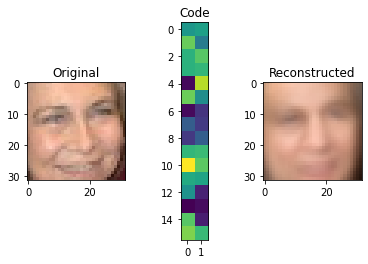

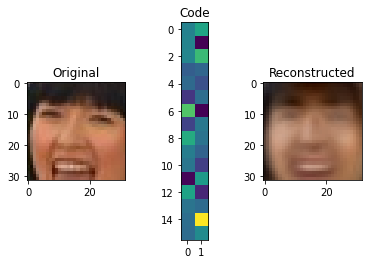

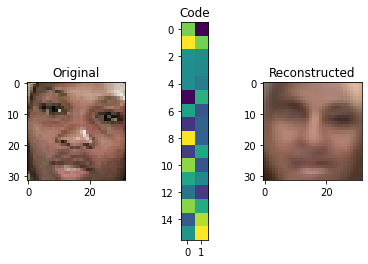

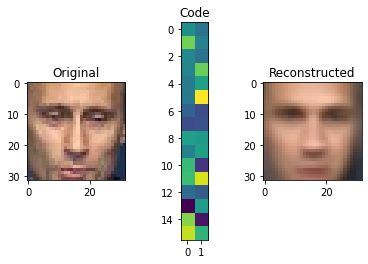

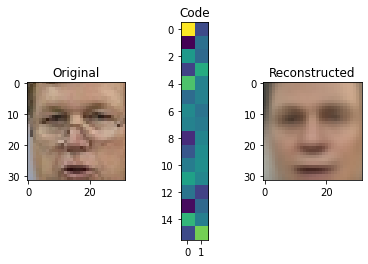

In [13]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

# 2. Convolutional Autoencoder

In [19]:
# Let's play around with transpose convolution on examples first
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).reshape((filter_size, filter_size, 1, 1))

    conv = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')

    print("input:")
    print(x[0, :, :, 0])
    print("filter:")
    print(f[:, :, 0, 0])
    print("output:")
    print(conv[0, :, :, 0])

        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
tf.Tensor(
[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]], shape=(4, 4), dtype=float32)
Transpose convolution test for img_size=2, filter_size=3:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
output:
tf.Tensor(
[[ 1.  1.  3.  2.]
 [ 1.  1.  3.  2.]
 [ 4.  4. 10.  6.]
 [ 3.  3.  7.  4.]], shape=(4, 4), dtype=float32)
Transpose convolution test for img_size=4, filter_size=2:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
tf.Tensor(
[[ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [13. 13. 14. 14. 15. 15. 16. 16.]
 [13. 13. 14. 14. 15. 15. 16. 16.]], shape=(8, 8), dtype=float32)
Transpose convolution tes

In [0]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(32, (3,3), strides = (1, 1), padding="same"))
    encoder.add(L.ELU())
    encoder.add(L.MaxPooling2D((2, 2)))

    encoder.add(L.Conv2D(64, (3,3), strides = (1, 1), padding="same"))
    encoder.add(L.ELU())
    encoder.add(L.MaxPooling2D((2, 2)))

    encoder.add(L.Conv2D(128, (3,3), strides = (1, 1), padding="same"))
    encoder.add(L.ELU())
    encoder.add(L.MaxPooling2D((2, 2)))

    encoder.add(L.Conv2D(256, (3,3), strides = (1, 1), padding="same"))
    encoder.add(L.ELU())
    encoder.add(L.MaxPooling2D((2, 2)))
      
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder
    

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(2 * 2 * 256))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape((2, 2, 256)))         #un-flatten
    
    decoder.add(L.Conv2DTranspose(128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(3, kernel_size=(3, 3), strides=2, activation = None, padding='same'))

    
    return encoder, decoder

In [33]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
   
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [34]:
# Total number of trainable parameters of encoder and decoder should be close.
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
elu_61 (ELU)                 (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
elu_62 (ELU)                 (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 8, 8, 128)       

In [0]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [0]:
# we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0:03d}.hdf5'

In [39]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                callbacks=[ModelSaveCallback(model_filename),
                           TqdmProgressCallback()],
                verbose=1,
                initial_epoch=last_finished_epoch or 0)

Train on 11828 samples, validate on 1315 samples
Epoch 1/25

Epoch 1/25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


11828/11828 [==============================] - 4s 309us/step - loss: 0.0119 - val_loss: 0.0081
Model saved in autoencoder.000.hdf5

Epoch 2/25

Epoch 2/25


11828/11828 [==============================] - 3s 257us/step - loss: 0.0076 - val_loss: 0.0072
Model saved in autoencoder.001.hdf5

Epoch 3/25

Epoch 3/25


11828/11828 [==============================] - 3s 256us/step - loss: 0.0071 - val_loss: 0.0070
Model saved in autoencoder.002.hdf5

Epoch 4/25

Epoch 4/25


11828/11828 [==============================] - 3s 254us/step - loss: 0.0070 - val_loss: 0.0068
Model saved in autoencoder.003.hdf5

Epoch 5/25

Epoch 5/25


11828/11828 [==============================] - 3s 255us/step - loss: 0.0068 - val_loss: 0.0067
Model saved in autoencoder.004.hdf5

Epoch 6/25

Epoch 6/25


11828/11828 [==============================] - 3s 255us/step - loss: 0.0067 - val_loss: 0.0066
Model saved in autoencoder.005.hdf5

Epoch 7/25

Epoch 7/25


11828/11828 [==============================] - 3s 257us/step - loss: 0.0067 - val_loss: 0.0066
Model saved in autoencoder.006.hdf5

Epoch 8/25

Epoch 8/25


11828/11828 [==============================] - 3s 257us/step - loss: 0.0065 - val_loss: 0.0064
Model saved in autoencoder.007.hdf5

Epoch 9/25

Epoch 9/25


11828/11828 [==============================] - 3s 257us/step - loss: 0.0064 - val_loss: 0.0063
Model saved in autoencoder.008.hdf5

Epoch 10/25

Epoch 10/25


11828/11828 [==============================] - 3s 256us/step - loss: 0.0063 - val_loss: 0.0062
Model saved in autoencoder.009.hdf5

Epoch 11/25

Epoch 11/25


11828/11828 [==============================] - 3s 261us/step - loss: 0.0061 - val_loss: 0.0061
Model saved in autoencoder.010.hdf5

Epoch 12/25

Epoch 12/25


11828/11828 [==============================] - 3s 258us/step - loss: 0.0060 - val_loss: 0.0060
Model saved in autoencoder.011.hdf5

Epoch 13/25

Epoch 13/25


11828/11828 [==============================] - 3s 262us/step - loss: 0.0059 - val_loss: 0.0059
Model saved in autoencoder.012.hdf5

Epoch 14/25

Epoch 14/25


11828/11828 [==============================] - 3s 258us/step - loss: 0.0058 - val_loss: 0.0058
Model saved in autoencoder.013.hdf5

Epoch 15/25

Epoch 15/25


11828/11828 [==============================] - 3s 255us/step - loss: 0.0057 - val_loss: 0.0058
Model saved in autoencoder.014.hdf5

Epoch 16/25

Epoch 16/25


11828/11828 [==============================] - 3s 252us/step - loss: 0.0057 - val_loss: 0.0057
Model saved in autoencoder.015.hdf5

Epoch 17/25

Epoch 17/25


11828/11828 [==============================] - 3s 253us/step - loss: 0.0056 - val_loss: 0.0057
Model saved in autoencoder.016.hdf5

Epoch 18/25

Epoch 18/25


11828/11828 [==============================] - 3s 253us/step - loss: 0.0055 - val_loss: 0.0057
Model saved in autoencoder.017.hdf5

Epoch 19/25

Epoch 19/25


11828/11828 [==============================] - 3s 257us/step - loss: 0.0055 - val_loss: 0.0056
Model saved in autoencoder.018.hdf5

Epoch 20/25

Epoch 20/25


11828/11828 [==============================] - 3s 254us/step - loss: 0.0054 - val_loss: 0.0056
Model saved in autoencoder.019.hdf5

Epoch 21/25

Epoch 21/25


11828/11828 [==============================] - 3s 253us/step - loss: 0.0054 - val_loss: 0.0056
Model saved in autoencoder.020.hdf5

Epoch 22/25

Epoch 22/25


11828/11828 [==============================] - 3s 252us/step - loss: 0.0053 - val_loss: 0.0055
Model saved in autoencoder.021.hdf5

Epoch 23/25

Epoch 23/25


11828/11828 [==============================] - 3s 258us/step - loss: 0.0053 - val_loss: 0.0055
Model saved in autoencoder.022.hdf5

Epoch 24/25

Epoch 24/25


11828/11828 [==============================] - 3s 255us/step - loss: 0.0052 - val_loss: 0.0055
Model saved in autoencoder.023.hdf5

Epoch 25/25

Epoch 25/25


11828/11828 [==============================] - 3s 254us/step - loss: 0.0052 - val_loss: 0.0055
Model saved in autoencoder.024.hdf5



Convolutional autoencoder MSE: 0.005462570967039398


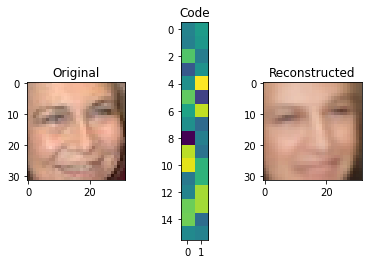

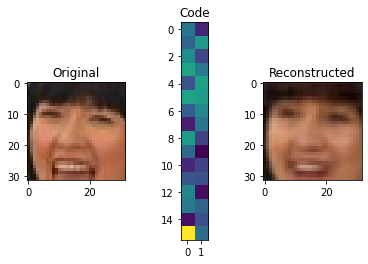

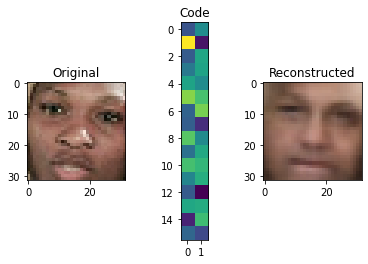

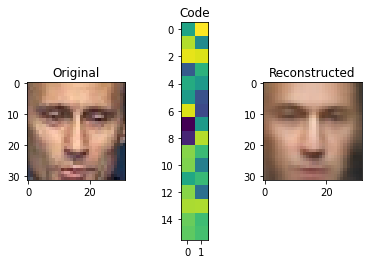

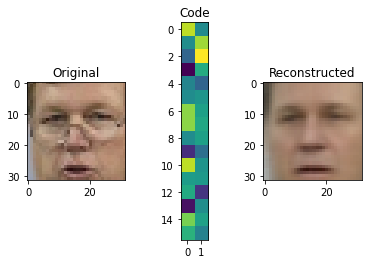

In [40]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [0]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [42]:
# restore trained weights
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=1))
print(reconstruction_mse)

1315/1315 [==============================] - 0s 121us/step
0.005462570978371079
0.005462570967039398


# 3. Denoising Autoencoder

The input data will be corrupted with Gaussian noise to see whether the previous architecture is able to denoise the input pictures. 

In [0]:
def apply_gaussian_noise(X,sigma=0.1):
    noise = np.random.normal(0, sigma, X.shape)
    return X + noise

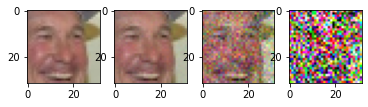

In [56]:
# test different noise scales
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

Train the autoencoder.

In [47]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)


inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    # we continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test],
                    callbacks=[TqdmProgressCallback()],
                    verbose=1)

Epoch 1/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


11828/11828 [==============================] - 4s 304us/step - loss: 0.0110 - val_loss: 0.0072

Epoch 2/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 267us/step - loss: 0.0064 - val_loss: 0.0057

Epoch 3/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 269us/step - loss: 0.0053 - val_loss: 0.0051

Epoch 4/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 270us/step - loss: 0.0048 - val_loss: 0.0046

Epoch 5/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 269us/step - loss: 0.0044 - val_loss: 0.0042

Epoch 6/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 270us/step - loss: 0.0041 - val_loss: 0.0041

Epoch 7/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 265us/step - loss: 0.0039 - val_loss: 0.0039

Epoch 8/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 278us/step - loss: 0.0037 - val_loss: 0.0036

Epoch 9/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 273us/step - loss: 0.0036 - val_loss: 0.0035

Epoch 10/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 274us/step - loss: 0.0034 - val_loss: 0.0034

Epoch 11/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 272us/step - loss: 0.0033 - val_loss: 0.0034

Epoch 12/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 270us/step - loss: 0.0032 - val_loss: 0.0033

Epoch 13/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 268us/step - loss: 0.0032 - val_loss: 0.0032

Epoch 14/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 275us/step - loss: 0.0031 - val_loss: 0.0032

Epoch 15/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 271us/step - loss: 0.0030 - val_loss: 0.0031

Epoch 16/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 269us/step - loss: 0.0030 - val_loss: 0.0031

Epoch 17/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 268us/step - loss: 0.0029 - val_loss: 0.0030

Epoch 18/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 270us/step - loss: 0.0029 - val_loss: 0.0030

Epoch 19/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 275us/step - loss: 0.0028 - val_loss: 0.0029

Epoch 20/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 270us/step - loss: 0.0028 - val_loss: 0.0029

Epoch 21/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 272us/step - loss: 0.0028 - val_loss: 0.0028

Epoch 22/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 273us/step - loss: 0.0027 - val_loss: 0.0028

Epoch 23/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 269us/step - loss: 0.0027 - val_loss: 0.0028

Epoch 24/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 273us/step - loss: 0.0027 - val_loss: 0.0028

Epoch 25/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1

Epoch 1/1


11828/11828 [==============================] - 3s 270us/step - loss: 0.0026 - val_loss: 0.0028



Denoising MSE: 0.0027899005836293724


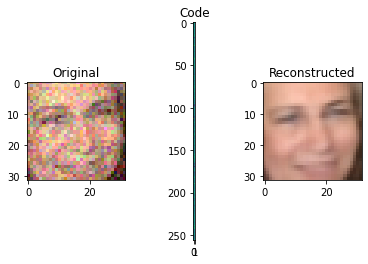

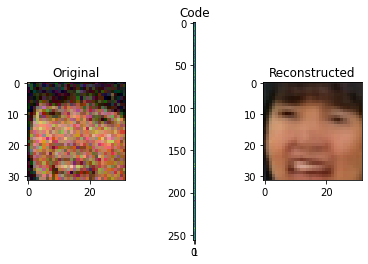

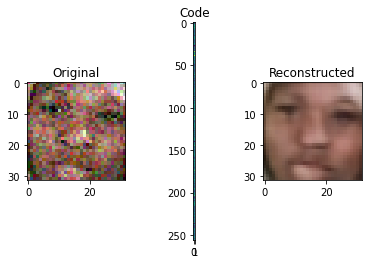

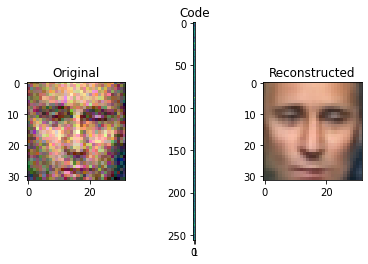

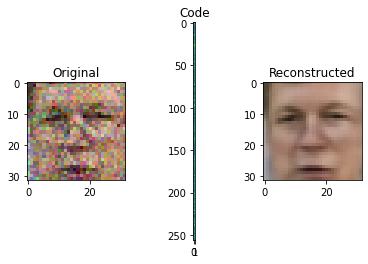

In [48]:
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

# Image Retrieval 
 
Extract features with an encoder and then find similar pictures in the feature space.

In [0]:
# restore trained encoder weights
#s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")

In [0]:
images = X_train
codes = encoder.predict(images)
assert len(codes) == len(images)

In [59]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [0]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [0]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Cherry-picked examples:

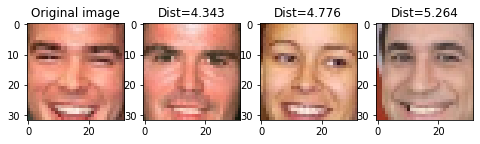

In [63]:
# smiles
show_similar(X_test[247])

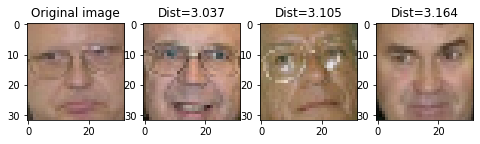

In [65]:
# glasses
show_similar(X_test[63])